In [2]:
# Import Dependencies and Configure Environment
import os, random
import numpy as np, pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score,
    confusion_matrix, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
RND = 42
os.environ['PYTHONHASHSEED'] = str(RND)
np.random.seed(RND)
random.seed(RND)
tf.random.set_seed(RND)


In [3]:
# Load and Inspect Dataset
df = pd.read_csv("processed_loan_data.csv", low_memory=False)
non_numeric = df.select_dtypes(exclude=[np.number]).columns.tolist()
print("Non-numeric columns:", non_numeric)


Non-numeric columns: ['term_ 60 months', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'verification_status_Source Verified', 'verification_status_Verified']


In [4]:
# Data Cleaning and Preprocessing
import datetime

# Convert earliest credit line to numeric age in years
if 'earliest_cr_line' in df.columns:
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], errors='coerce')
    today = datetime.datetime(2019, 1, 1)
    df['credit_age_years'] = (today - df['earliest_cr_line']).dt.days / 365.25
    df.drop(columns=['earliest_cr_line'], inplace=True)

# Convert boolean columns to integers
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
    df[bool_cols] = df[bool_cols].astype(int)

# Force all columns to numeric, replace NaN with 0
df = df.apply(pd.to_numeric, errors='coerce').fillna(0)


In [5]:
# Data Type Validation and Summary Statistics
assert df.select_dtypes(exclude=[np.number]).empty, "Non-numeric columns still exist"
print("Final shape:", df.shape)
print(df.info())
print(df.describe().T.head(10))


Final shape: (1803164, 42)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803164 entries, 0 to 1803163
Data columns (total 42 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   loan_amnt                            float64
 1   funded_amnt                          float64
 2   int_rate                             float64
 3   installment                          float64
 4   annual_inc                           float64
 5   dti                                  float64
 6   delinq_2yrs                          float64
 7   inq_last_6mths                       float64
 8   open_acc                             float64
 9   pub_rec                              float64
 10  revol_bal                            float64
 11  revol_util                           float64
 12  total_acc                            float64
 13  emp_length                           float64
 14  target                               float64
 15  term_

In [6]:
# Define Features and Target Variable
X = df.drop(columns=['target']).values.astype(np.float32)
y = df['target'].astype(int).values
print(f"Shape: {X.shape}, Default rate: {y.mean():.3f}")


Shape: (1803164, 41), Default rate: 0.149


In [7]:
# Split Data into Train, Validation, and Test Sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RND
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RND
)


In [8]:
# Handle Class Imbalance using RandomOverSampler
ros = RandomOverSampler(random_state=RND)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
print("Training balance:", np.bincount(y_train_res))


Training balance: [1074245 1074245]


In [9]:
# Define the MLP Model Architecture
def build_mlp(input_dim, hidden=[256, 128, 64], dropout=0.3, l2=1e-5):
    model = Sequential()
    for i, h in enumerate(hidden):
        if i == 0:
            model.add(Dense(h, input_dim=input_dim, activation='relu',
                            kernel_regularizer=regularizers.l2(l2)))
        else:
            model.add(Dense(h, activation='relu', kernel_regularizer=regularizers.l2(l2)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return model

model = build_mlp(X_train_res.shape[1])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        10,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,761 (210.00 KB)

 Trainable params: 52,865 (206.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [10]:
# Set Up Callbacks for Early Stopping and Model Checkpointing
es = EarlyStopping(monitor='val_auc', mode='max', patience=8,
                   restore_best_weights=True, verbose=1)
mc = ModelCheckpoint("keras_default_pred.h5", monitor='val_auc', mode='max',
                     save_best_only=True, verbose=1)


In [11]:
# Train the Model
history = model.fit(
    X_train_res, y_train_res,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=512,
    callbacks=[es, mc],
    verbose=2
)


Epoch 1/100

Epoch 1: val_auc improved from -inf to 0.78636, saving model to keras_default_pred.h5


4197/4197 - 62s - 15ms/step - auc: 0.7785 - loss: 0.5392 - val_auc: 0.7864 - val_loss: 0.5558
Epoch 2/100

Epoch 2: val_auc improved from 0.78636 to 0.78664, saving model to keras_default_pred.h5


4197/4197 - 57s - 14ms/step - auc: 0.7856 - loss: 0.5295 - val_auc: 0.7866 - val_loss: 0.5560
Epoch 3/100

Epoch 3: val_auc did not improve from 0.78664
4197/4197 - 56s - 13ms/step - auc: 0.7861 - loss: 0.5285 - val_auc: 0.7866 - val_loss: 0.5491
Epoch 4/100

Epoch 4: val_auc did not improve from 0.78664
4197/4197 - 60s - 14ms/step - auc: 0.7864 - loss: 0.5280 - val_auc: 0.7865 - val_loss: 0.5465
Epoch 5/100

Epoch 5: val_auc improved from 0.78664 to 0.78672, saving model to keras_default_pred.h5


4197/4197 - 56s - 13ms/step - auc: 0.7865 - loss: 0.5279 - val_auc: 0.7867 - val_loss: 0.5505
Epoch 6/100

Epoch 6: val_auc improved from 0.78672 to 0.78676, saving model to keras_default_pred.h5


4197/4197 - 56s - 13ms/step - auc: 0.7866 - loss: 0.5278 - val_auc: 0.7868 - val_loss: 0.5515
Epoch 7/100

Epoch 7: val_auc did not improve from 0.78676
4197/4197 - 58s - 14ms/step - auc: 0.7867 - loss: 0.5276 - val_auc: 0.7867 - val_loss: 0.5498
Epoch 8/100

Epoch 8: val_auc did not improve from 0.78676
4197/4197 - 57s - 14ms/step - auc: 0.7868 - loss: 0.5276 - val_auc: 0.7868 - val_loss: 0.5510
Epoch 9/100

Epoch 9: val_auc did not improve from 0.78676
4197/4197 - 57s - 13ms/step - auc: 0.7869 - loss: 0.5275 - val_auc: 0.7866 - val_loss: 0.5425
Epoch 10/100

Epoch 10: val_auc improved from 0.78676 to 0.78679, saving model to keras_default_pred.h5


4197/4197 - 62s - 15ms/step - auc: 0.7869 - loss: 0.5275 - val_auc: 0.7868 - val_loss: 0.5435
Epoch 11/100

Epoch 11: val_auc did not improve from 0.78679
4197/4197 - 56s - 13ms/step - auc: 0.7870 - loss: 0.5274 - val_auc: 0.7866 - val_loss: 0.5451
Epoch 12/100

Epoch 12: val_auc did not improve from 0.78679
4197/4197 - 57s - 13ms/step - auc: 0.7871 - loss: 0.5273 - val_auc: 0.7867 - val_loss: 0.5461
Epoch 13/100

Epoch 13: val_auc improved from 0.78679 to 0.78693, saving model to keras_default_pred.h5


4197/4197 - 55s - 13ms/step - auc: 0.7871 - loss: 0.5272 - val_auc: 0.7869 - val_loss: 0.5427
Epoch 14/100

Epoch 14: val_auc did not improve from 0.78693
4197/4197 - 55s - 13ms/step - auc: 0.7872 - loss: 0.5272 - val_auc: 0.7867 - val_loss: 0.5424
Epoch 15/100

Epoch 15: val_auc did not improve from 0.78693
4197/4197 - 56s - 13ms/step - auc: 0.7871 - loss: 0.5272 - val_auc: 0.7866 - val_loss: 0.5422
Epoch 16/100

Epoch 16: val_auc did not improve from 0.78693
4197/4197 - 57s - 14ms/step - auc: 0.7871 - loss: 0.5272 - val_auc: 0.7868 - val_loss: 0.5478
Epoch 17/100

Epoch 17: val_auc improved from 0.78693 to 0.78697, saving model to keras_default_pred.h5


4197/4197 - 56s - 13ms/step - auc: 0.7871 - loss: 0.5272 - val_auc: 0.7870 - val_loss: 0.5495
Epoch 18/100

Epoch 18: val_auc did not improve from 0.78697
4197/4197 - 55s - 13ms/step - auc: 0.7872 - loss: 0.5272 - val_auc: 0.7869 - val_loss: 0.5457
Epoch 19/100

Epoch 19: val_auc did not improve from 0.78697
4197/4197 - 55s - 13ms/step - auc: 0.7872 - loss: 0.5271 - val_auc: 0.7868 - val_loss: 0.5421
Epoch 20/100

Epoch 20: val_auc did not improve from 0.78697
4197/4197 - 58s - 14ms/step - auc: 0.7873 - loss: 0.5271 - val_auc: 0.7868 - val_loss: 0.5442
Epoch 21/100

Epoch 21: val_auc did not improve from 0.78697
4197/4197 - 58s - 14ms/step - auc: 0.7873 - loss: 0.5271 - val_auc: 0.7868 - val_loss: 0.5496
Epoch 22/100

Epoch 22: val_auc did not improve from 0.78697
4197/4197 - 58s - 14ms/step - auc: 0.7873 - loss: 0.5271 - val_auc: 0.7868 - val_loss: 0.5481
Epoch 23/100

Epoch 23: val_auc did not improve from 0.78697
4197/4197 - 56s - 13ms/step - auc: 0.7873 - loss: 0.5271 - val_auc: 0.

In [12]:
# Load Best Model and Evaluate Performance on Test Set
model = tf.keras.models.load_model("keras_default_pred.h5")
p_test = model.predict(X_test, batch_size=512).ravel()
y_pred = (p_test >= 0.5).astype(int)

print(f"AUC: {roc_auc_score(y_test, p_test):.4f}")
print(f"F1: {f1_score(y_test, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
AUC: 0.7880
F1: 0.4072
Accuracy: 0.6590
Confusion matrix:
 [[146578  83618]
 [  8605  31674]]


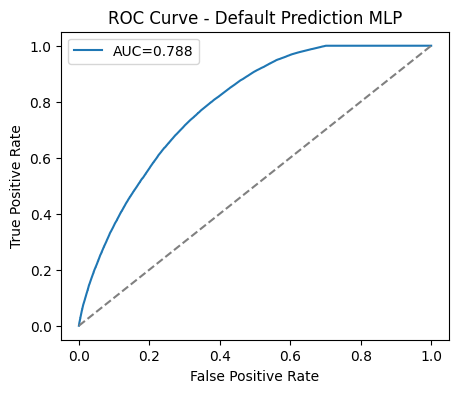

In [13]:
# Plot ROC Curve for Model Performance Visualization
fpr, tpr, _ = roc_curve(y_test, p_test)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, p_test):.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Default Prediction MLP")
plt.legend()
plt.show()


In [14]:
# Save Test Predictions for Offline RL Pipeline
out = pd.DataFrame({
    "y_true": y_test,
    "p_default": p_test
})
out.to_csv("test_predictions.csv", index=False)
print("Saved test predictions to test_predictions.csv")


Saved test predictions to test_predictions.csv
